### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'sf_permits',
    'source': 'kaggle',
    'remote_path': 'aparnashastry/building-permit-applications-data',
    'files': ['Building_Permits.csv'],
    'rename_files': ['sf_permits.csv'],
    'task': 'reg',
    'target': 'time_to_approve',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/sf_permits.
Downloaded sf_permits dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/sf_permits


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns, convert_column_to_unix
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/sf_permits/sf_permits.csv


/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/dataloader_functions/utils/data_2_df.py:97: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(file_path, delimiter=delimiter, encoding=encoding)


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.52

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    # df_file = df_file[df_file[dataset_config['target']].notna()] # ->  have not created the target column yet
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Street Number Suffix', 'Unit', 'Unit Suffix',
       'Structural Notification', 'Voluntary Soft-Story Retrofit',
       'Fire Only Permit', 'TIDF Compliance', 'Site Permit'],
      dtype='object')
Dataframe shape before/afrer cleaning: (198900, 43) / (198900, 35)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns (and target leakage)

# Permit Number, Record ID -> no inforation value
# 'Permit Expiration Date', 'Completed Date', 'First Construction Document Date', 'Current Status Date' -> target leakage
# Permit Creation Date -> duplicate of Filed Date

cols_to_drop = ['Permit Number', 'Record ID', 'Permit Expiration Date', 'Completed Date', 'First Construction Document Date', 'Current Status Date', 'Permit Creation Date']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

Dataframe shape before/afrer by-hand cleaning: (198900, 35) / (198900, 28)


In [8]:
import copy
import numpy as np

tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    # 1. Create target column BEFORE overwriting dates
    filed_date = pd.to_datetime(df_file['Filed Date'], errors='coerce')
    issued_date = pd.to_datetime(df_file['Issued Date'], errors='coerce')

    df_file[dataset_config['target']] = (issued_date - filed_date).dt.days
    # df_file.loc[issued_date.isna() | filed_date.isna(), dataset_config['target']] = float('inf') # setting to inf if either date is missing

    df_file.drop(['Issued Date'], axis=1, inplace=True)

    # 2. Split Location into latitude & longitude
    if 'Location' in df_file.columns:
        location_split = df_file['Location'].str.split(',', expand=True)
        location_split[0] = location_split[0].str.replace('(', '', regex=False).apply(pd.to_numeric, errors='coerce')
        location_split[1] = location_split[1].str.replace(')', '', regex=False).apply(pd.to_numeric, errors='coerce')
        location_split.columns = ['Location_Latitude', 'Location_Longitude']
        df_file = pd.concat([df_file, location_split], axis=1)
        df_file.drop(['Location'], axis=1, inplace=True)

    if True: # TODO: by default we transform all dataetime columns to UNIX timestamp
        # 3. Convert Filed Date to UNIX timestamp AFTER using it for target
        df_file['Filed Date'] = filed_date.apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

    # 4. drop all rows with unreasonable large target values
    df_file = df_file[df_file[dataset_config['target']] < 1000] # TODO: set a threshold for the target value

    # 5. drop all that are too short
    df_file = df_file[df_file[dataset_config['target']] >= 0] # TODO: set a threshold for the target value

    print(f"Dataframe shape after custom cleaning: {df_file.shape}")
    dataset_files_by_hand_cleaned.append(df_file)

# Restore original if needed
dataset_files_cleaned = tmp_df


Dataframe shape before custom cleaning: (198900, 28)
Dataframe shape after custom cleaning: (183794, 29)


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

# dataset_files_cleaned[0].head(n=3)
dataset_files_by_hand_cleaned[0].head(n=3)

,Permit Type,Permit Type Definition,Block,Lot,Street Number,Street Name,Street Suffix,Description,Current Status,Filed Date,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,time_to_approve,Location_Latitude,Location_Longitude
0,4,sign - erect,0326,023,140,Ellis,St,"ground fl facade: to erect illuminated, electr...",expired,1.430870e+09,6.0,NaN,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,3.0,constr type 3,NaN,NaN,3.0,Tenderloin,94102.0,187.0,37.785719,-122.408523
1,4,sign - erect,0306,007,440,Geary,St,remove (e) awning and associated signs.,issued,1.461024e+09,7.0,NaN,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,3.0,constr type 3,NaN,NaN,3.0,Tenderloin,94102.0,471.0,37.787340,-122.410632
3,8,otc alterations permit,0156,011,1230,Pacific,Av,repair dryrot & stucco at front of bldg.,complete,1.478477e+09,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,5.0,wood frame (5),5.0,wood frame (5),3.0,Nob Hill,94109.0,253.0,37.795959,-122.415574


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (12): ['Block', 'Street Number', 'Filed Date', 'Number of Existing Stories', 'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 'Existing Units', 'Proposed Units', 'time_to_approve', 'Location_Latitude', 'Location_Longitude']
Categorical columns (12): ['Permit Type', 'Permit Type Definition', 'Street Suffix', 'Current Status', 'Plansets', 'Existing Construction Type', 'Existing Construction Type Description', 'Proposed Construction Type', 'Proposed Construction Type Description', 'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode']
Textual columns (5): ['Lot', 'Street Name', 'Description', 'Existing Use', 'Proposed Use']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Permit Type,4,categorical,8
1,Permit Type Definition,sign - erect,categorical,8
2,Block,0326,numerical,~ 4881 ~
3,Lot,023,textual,1048
4,Street Number,140,numerical,~ 5051 ~
5,Street Name,Ellis,textual,1690
6,Street Suffix,St,categorical,21
7,Description,"ground fl facade: to erect illuminated, electr...",textual,122496
8,Current Status,expired,categorical,10
9,Filed Date,1430870400.0,numerical,~ 1288 ~


#### We also need to make sure that numerical columns are actually numerical :)

In [12]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


Column 'Block' requires cleaning (non-numeric artifacts found).


,Column Name,Example Value,Type,# Categories
0,Permit Type,4,categorical,8
1,Permit Type Definition,sign - erect,categorical,8
2,Block,326.0,numerical,4689
3,Lot,023,textual,1048
4,Street Number,140.0,numerical,5051
5,Street Name,Ellis,textual,1690
6,Street Suffix,St,categorical,21
7,Description,"ground fl facade: to erect illuminated, electr...",textual,122496
8,Current Status,expired,categorical,10
9,Filed Date,1430870400.0,numerical,1288


### Saving the processed data and loading it back up

In [13]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/sf_permits/sf_permits_processed.pkl


In [14]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== SF_PERMITS ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Permit Type,categorical,8
1,Permit Type Definition,categorical,8
2,Block,numerical,4689
3,Lot,textual,1048
4,Street Number,numerical,5051
5,Street Name,textual,1690
6,Street Suffix,categorical,21
7,Description,textual,122496
8,Current Status,categorical,10
9,Filed Date,numerical,1288


Column Name,Permit Type,Permit Type Definition,Block,Lot,Street Number,Street Name,Street Suffix,Description,Current Status,Filed Date,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,time_to_approve,Location_Latitude,Location_Longitude
0,4,sign - erect,326.0,023,140.0,Ellis,St,"ground fl facade: to erect illuminated, electr...",expired,1.430870e+09,6.0,NaN,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,3.0,constr type 3,NaN,NaN,3.0,Tenderloin,94102.0,187.0,37.785719,-122.408523
1,4,sign - erect,306.0,007,440.0,Geary,St,remove (e) awning and associated signs.,issued,1.461024e+09,7.0,NaN,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,3.0,constr type 3,NaN,NaN,3.0,Tenderloin,94102.0,471.0,37.787340,-122.410632
3,8,otc alterations permit,156.0,011,1230.0,Pacific,Av,repair dryrot & stucco at front of bldg.,complete,1.478477e+09,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,5.0,wood frame (5),5.0,wood frame (5),3.0,Nob Hill,94109.0,253.0,37.795959,-122.415574


### Bonus insights (Regression)

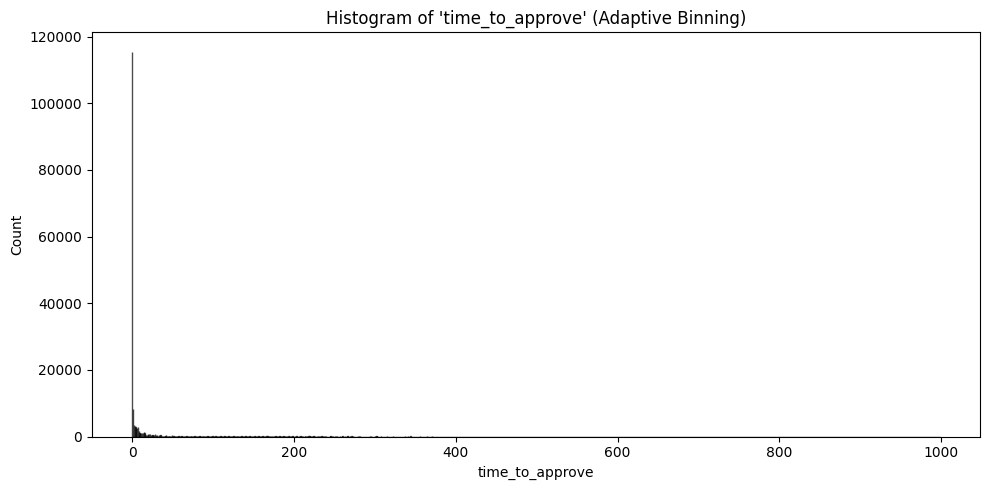

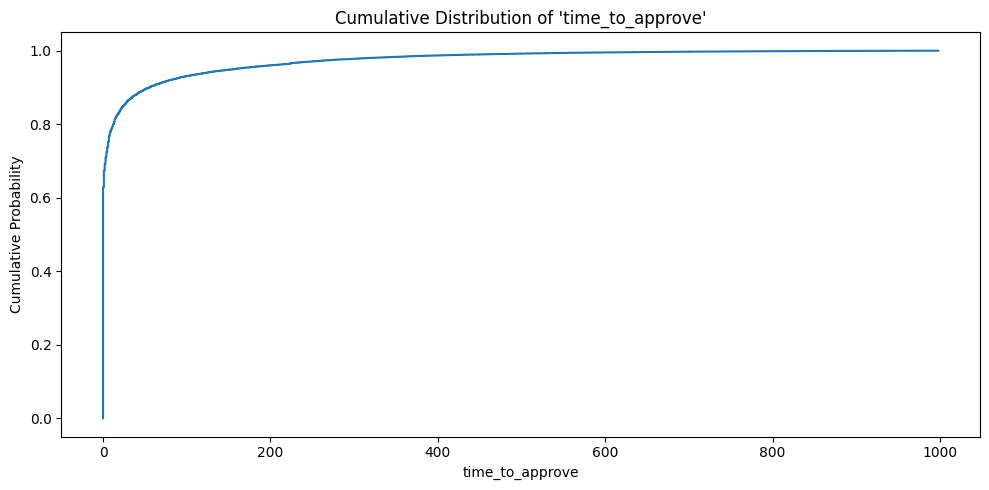

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']].dropna()  # Drop NaN upfront

if target_series.empty:
    print(f"⚠️ Target column '{dataset_config['target']}' is empty after dropping NaNs. Skipping plot.")
else:
    # 1️⃣ Histogram with Freedman-Diaconis rule for binning
    q25, q75 = np.percentile(target_series, [25, 75])
    iqr = q75 - q25

    # Handle constant values or iqr == 0 case
    if iqr == 0 or np.isnan(iqr):
        print(f"⚠️ IQR is zero or NaN. Falling back to default bin count.")
        bin_count = 10
    else:
        bin_width = 2 * iqr * len(target_series) ** (-1/3)
        if bin_width <= 0 or np.isnan(bin_width):
            print(f"⚠️ Computed bin_width is invalid ({bin_width}). Falling back to default bin count.")
            bin_count = 10
        else:
            bin_count = int((target_series.max() - target_series.min()) / bin_width)
            bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

    plt.figure(figsize=(10, 5))
    plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
    plt.xlabel(dataset_config['target'])
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # 2️⃣ Cumulative Distribution Function (CDF)
    target_sorted = target_series.sort_values()
    cdf = np.arange(len(target_sorted)) / len(target_sorted)

    plt.figure(figsize=(10, 5))
    plt.plot(target_sorted, cdf, color='tab:blue')
    plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
    plt.xlabel(dataset_config['target'])
    plt.ylabel('Cumulative Probability')
    plt.tight_layout()
    plt.show()


In [16]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_160018"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       456.40 GB / 503.54 GB (90.6%)
Disk Space Avail:   33796.65 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: reg
Info: 
[INFO] Downsampling dataframe: sf_permits (original rows: 183794)
Downsampled 3000 rows for sf_permits dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/AutogluonModels/ag-20250521_160018"
Train Data Rows:    2400
Train Data Columns: 28
Label Column:       time_to_approve
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    467394.82 MB
	Train Data (Original)  Memory Usage: 2.14 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
		Fitting DatetimeFeatureGenerator...
		Fitting TextSpecia

In [17]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.426736  0.072611
 AutoGluon_Tabular_with_text     0.439638  0.093011,
 'loss':                                      mean       std
 model                                              
 AutoGluon_Tabular_with_text     60.567136  7.797099
 AutoGluon_Tabular_without_text  61.300399  6.946517,
 'roc_auc':                                 mean  std
 model                                    
 AutoGluon_Tabular_with_text      NaN  NaN
 AutoGluon_Tabular_without_text   NaN  NaN}